For this week's assignment I implemented true online Sarsa($\lambda$) and regular online Sarsa($\lambda$) on a corridor domain. 

The domain is a 19 state corridor in which there are only two actions [left, right]. The episode terminates once the agent reaches one of the two extreme sides of the corridor. The agent receives a +1 reward if it reaches the right side of the corridor, otherwise a 0 reward is obtained at every time step. 

Here I consider the control problem - predicting not just values but state action values that can be used to determine a policy. Here I use an $\epsilon$ greedy policy with $\epsilon = 0.1$.

I compare online Sarsa($\lambda$) and true online Sarsa($\lambda$) with $\lambda =0.9$ and several values of $\alpha$.

In [1]:
class Corridor(object):
    def __init__(self, num_states=5, max_steps=1000):
        self.num_states = num_states
        self.state_shape = [num_states]
        self.nb_actions = 2
        self.state = np.zeros(num_states, dtype='float32')
        self.start_pos = int(num_states / 2)
        self.pos = self.start_pos
        self.max_steps= max_steps
        self.counter = 0

    def observe(self):
        return np.copy(self.state)

    def _is_over(self):
        # exit or max number of steps
        return self.pos == -1 or self.pos == self.num_states or self.counter == self.max_steps

    def _update_state(self, action):
        if action == 0 and self.pos == 0:
            self.state = np.zeros(self.num_states, dtype='float32')
            self.pos -= 1
        elif action == 1 and self.pos == self.num_states - 1:
            self.state = np.zeros(self.num_states, dtype='float32')
            self.pos += 1
        elif action == 0:  # move left
            self.state = np.zeros(self.num_states, dtype='float32')
            self.state[self.pos - 1] = 1
            self.pos -= 1
        elif action == 1:  # move right
            self.state = np.zeros(self.num_states, dtype='float32')
            self.state[self.pos + 1] = 1
            self.pos += 1

    def _get_reward(self):
        if self.pos == self.num_states:
            reward = 1.0
        else:
            reward = 0.0
        return reward

    def act(self, action):
        assert action == 0 or action == 1 or action == 2
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        self.counter += 1
        # #
        return self.observe(), reward, game_over

    def reset(self):
        self.state = np.zeros(self.num_states, dtype='float32')
        self.state[self.start_pos] = 1
        self.pos = self.start_pos
        self.counter = 0

In [2]:
import numpy as np


class SarsaLambdaAgent(object):
    def __init__(self, state_shape, nb_actions, gamma=1.0, lambd=0.0, lr=0.1, init=0):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.gamma = gamma
        self.lambd = lambd
        self.lr = lr
        self.init = init
        self.e = np.zeros((self.state_shape[0], self.nb_actions))
        self.theta = np.ones((self.state_shape[0], self.nb_actions)) * init
        
    def get_value(self, phi):
        return np.dot(self.theta.T, phi)

    def get_action(self, phi, epsilon):
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            return np.argmax(self.get_value(phi))

    def learn(self, s, a, r, s2, a2, t):
        pred = self.get_value(s)[a]
        target = r + (1 - t) * self.gamma * self.get_value(s2)[a2]
        s_expanded = np.zeros(self.theta.shape)
        s_expanded[:, a] = s
        self.e = s_expanded + self.gamma * self.lambd * self.e
        self.theta += self.lr * (target - pred) * self.e

    def reset_trace(self):
        self.e = np.zeros((self.state_shape[0], self.nb_actions))
    
    def reset(self):
        self.e = np.zeros((self.state_shape[0], self.nb_actions))
        self.theta = np.ones((self.state_shape[0], self.nb_actions)) * init

        
class TrueSarsaLambdaAgent(object):
    def __init__(self, state_shape, nb_actions, gamma=1.0, lambd=0.0, lr=0.1, init=0):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.gamma = gamma
        self.lambd = lambd
        self.lr = lr
        self.init = init
        self.e = np.zeros((self.state_shape[0], self.nb_actions))
        self.theta = np.ones((self.state_shape[0], self.nb_actions)) * init
        self.v_old = 0
        
    def get_value(self, phi):
        return np.dot(self.theta.T, phi)

    def get_action(self, phi, epsilon):
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            return np.argmax(self.get_value(phi))

    def learn(self, s, a, r, s2, a2, t):
        s_expanded = np.zeros(self.theta.shape)
        s_expanded[:, a] = s
        
        v = self.get_value(s)[a]
        v2 = self.get_value(s2)[a2]
        delta = r + (1 - t) * self.gamma * v2 - v
        
        self.e = self.gamma * self.lambd * self.e + s_expanded * \
                 (np.ones((self.nb_actions)) - self.lr * self.gamma * self.lambd * np.dot(self.e.T, s))
        
        theta_update = self.lr * (delta + v - self.v_old) * self.e - self.lr * (v - self.v_old) * s_expanded
        self.theta += theta_update
        self.v_old = v2

    def reset_trace(self):
        self.e = np.zeros((self.state_shape[0], self.nb_actions))
    
    def reset(self):
        self.e = np.zeros((self.state_shape[0], self.nb_actions))
        self.theta = np.ones((self.state_shape[0], self.nb_actions)) * init

In [3]:
import numpy as np
import pickle

nb_runs = 5
nb_episodes = 50
lambdas = [0.9]
alphas = [0.01, 0.1, 0.2, 0.5, 1.0]
epsilon = 0.1
env = Corridor(num_states=19)
ais = [SarsaLambdaAgent, TrueSarsaLambdaAgent]
storages = [np.empty((nb_runs, len(alphas), len(lambdas))) for ai in ais]
ai_names = [ai.__name__ for ai in ais]

def do_episode(env, agent, epsilon=0.1, learn=True):
    env.reset()
    terminal = False
    rewards = 0
    s = env.observe()
    while not terminal:
        a = agent.get_action(s, epsilon)
        s2, r, terminal = env.act(a)
        rewards += r
        a2 = agent.get_action(s2, epsilon)
        if learn:
            agent.learn(s, a, r, s2, a2, terminal)
        s = s2
    return rewards


def do_experiment(env, ai, nb_runs, nb_episodes, alphas, lambdas, epsilon, storage):
    for run in range(nb_runs):
        for a, alpha in enumerate(alphas):
            for l, lambd in enumerate(lambdas):
                agent = ai(env.state_shape, env.nb_actions, lr=alpha, lambd=lambd, init=0.5)
                cumul_reward = 0
                for ep in range(nb_episodes):
                    agent.reset_trace()
                    reward = do_episode(env, agent, epsilon=epsilon, learn=True)
                    cumul_reward += reward
                storage[run, a, l] = cumul_reward / nb_episodes

for ai, storage in zip(ais, storages):
    do_experiment(env, ai, nb_runs, nb_episodes, alphas, lambdas, epsilon, storage)

for storage, name in zip(storages, ai_names):
    with open(name, 'wb') as f:
        pickle.dump(storage, f)

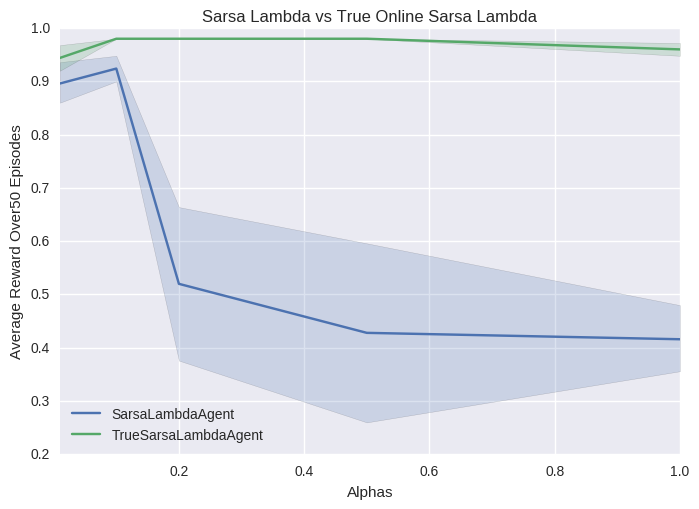

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pickle

agent_scores = []
for name in ai_names:
    with open(name, 'rb') as f:
        scores = pickle.load(f)
        agent_scores.append(scores)

agent_scores = np.stack(agent_scores, axis=2).squeeze(axis=-1)
plot = seaborn.tsplot(data=agent_scores, time=alphas, legend=True, condition=ai_names)
plot.set_title("Sarsa Lambda vs True Online Sarsa Lambda")
plot.set_ylabel("Average Reward Over" + str(nb_episodes) + " Episodes")
plot.set_xlabel("Alphas")